# Importing and loading necessary libraries

In [67]:
import numpy as np
import cv2
import random
import os

from imutils import paths


from keras.models import Sequential,load_model
from keras.layers.core import Activation
from keras.preprocessing.image import img_to_array,ImageDataGenerator
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, precision_recall_fscore_support, average_precision_score, confusion_matrix
from sklearn.model_selection import train_test_split

import warnings 
warnings.filterwarnings("ignore",category=UserWarning)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Load the data

In [16]:
PATH = "/Users/noor-4785/Desktop/food_5k/test"
# PATH = "/content/drive/My Drive/Colab Notebooks/VIT_FDP_CV/data/food_5k"



# Load and preprocess data

In [49]:
# Initialise required variables
data = []
labels = []
features = []
RANDOM_STATE = 42

In [50]:
# Initialise required hyperparameters
IMAGE_DIM = 48
TEST_SPLIT = 0.20
BATCH_SIZE = 32
EPOCHS = 5
INIT_LR = 1e-3

In [51]:
# Extracting the class information from the given folder : Class name and corresponding number of files
class_dir_paths = os.listdir(PATH)
class_dict = {}
idx = 0

for class_dir_path in class_dir_paths:
    if (os.path.isdir(os.path.join(PATH, class_dir_path))):
        class_name = class_dir_path
        class_dict[class_name] = idx
        idx += 1

print("Class information : ", class_dict)

Class information :  {'notfood': 0, 'food': 1}


In [52]:
# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images(PATH)))
random.seed(RANDOM_STATE)
random.shuffle(imagePaths)

In [53]:
len(imagePaths)

1000

In [54]:
imagePaths[5]

'/Users/noor-4785/Desktop/food_5k/test/food/1_84.jpg'

In [55]:
# resize the image to a fixed size, then flatten the image into
# a list of raw pixel intensities

def image_to_feature_vector(image, size=(32, 32)):
    return cv2.resize(image, size).flatten()

# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIM, IMAGE_DIM))
    image = img_to_array(image)
    feature = image_to_feature_vector(image)
    data.append(image)
    features.append(feature)

    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(class_dict[label])

print("Total number of images readed, ", len(data))
print("Total number of labels extracted, ", len(labels))

Total number of images readed,  1000
Total number of labels extracted,  1000


In [56]:
# labels

# Convolutional Neural network

In [57]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [58]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=TEST_SPLIT, random_state=RANDOM_STATE)

print("Number of image in training set ", len(trainX), len(trainY))
print("Number of image in tesing set ", len(testX), len(testY))

Number of image in training set  800 800
Number of image in tesing set  200 200


In [59]:
# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=len(class_dict))
testY = to_categorical(testY, num_classes=len(class_dict))

In [68]:
def simple_net(width, height, depth, classes):

    finalAct = "softmax" if classes > 2 else "sigmoid"

    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)

    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)

    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(20, (5, 5), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation(finalAct))

    # return the constructed network architecture
    return model

In [69]:
aug = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

In [70]:
model = simple_net(IMAGE_DIM, IMAGE_DIM, 3, len(class_dict))

In [71]:
# Choose the optimizer
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

# Complile the model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [72]:
print("[INFO] training network...")
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1)

[INFO] training network...
Epoch 1/5
25/25 [==============================] - 4s 167ms/step - loss: 0.6287 - acc: 0.6444 - val_loss: 0.4870 - val_acc: 0.7525
Epoch 2/5
25/25 [==============================] - 3s 139ms/step - loss: 0.5063 - acc: 0.7612 - val_loss: 0.5637 - val_acc: 0.7775
Epoch 3/5
25/25 [==============================] - 4s 147ms/step - loss: 0.5113 - acc: 0.7519 - val_loss: 0.4256 - val_acc: 0.8000
Epoch 4/5
25/25 [==============================] - 4s 149ms/step - loss: 0.4648 - acc: 0.7894 - val_loss: 0.4617 - val_acc: 0.7750
Epoch 5/5
25/25 [==============================] - 4s 147ms/step - loss: 0.4394 - acc: 0.8050 - val_loss: 0.3922 - val_acc: 0.8225


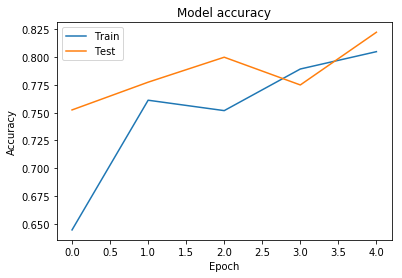

In [73]:
# Plot training & validation accuracy values
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [74]:
print_score(model,trainX, trainY, testX, testY)

200/200 [==============================] - 0s 1ms/step
************ Training Metrics ************
Accuracy =  0.83
Confusion Matrix
[[365  41]
 [ 95 299]]
************ Testing Metrics ************
Accuracy =  0.8225
Confusion Matrix
[[87  7]
 [29 77]]


## To save the model

In [84]:
model.save('simple_cnn_model')

## Load the saved model and do prediction

In [106]:
# load the trained convolutional neural network
print("[INFO] loading network...")
model = load_model('simple_cnn_model')

[INFO] loading network...


In [107]:
# load the image
image = cv2.imread('/Users/noor-4785/Desktop/food_5k/test/food/1_101.jpg')

# pre-process the image for classification
image = cv2.resize(image, (IMAGE_DIM, IMAGE_DIM))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

In [108]:
(notfood, food) = model.predict(image)[0]

In [109]:
# One with the highest value is our prediction
(notfood, food)

(0.21205305, 0.80802953)

# utils

In [110]:
def print_score(model, trainX, trainY, testX, testY):

    train_score = model.evaluate(trainX, trainY)
    train_predictions = model.predict(trainX)
    train_predictions = np.round(train_predictions)

    test_score = model.evaluate(testX, testY)
    test_predictions = model.predict(testX)
    test_predictions = np.round(test_predictions)

    print("************ Training Metrics ************")

#     print("Loss = ", train_score[0])
    print("Accuracy = ", train_score[1])
#     print("classification Report")
#     print(classification_report(trainY, train_predictions))
    print("Confusion Matrix")
    train_cm = confusion_matrix(
        trainY.argmax(axis=1), train_predictions.argmax(axis=1))
    print(train_cm)

    print("************ Testing Metrics ************")

#     print("Loss = ", test_score[0])
    print("Accuracy = ", test_score[1])
#     print("classification Report")
#     print(classification_report(testY, test_predictions))
    print("Confusion Matrix")
    test_cm = confusion_matrix(
        testY.argmax(axis=1), test_predictions.argmax(axis=1))
    print(test_cm)